In [2]:
from keras import layers
from keras import regularizers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
import pandas as pd
import os
import cv2
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\adarabi3\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [3]:
training_data=[]
datadir="C:/Users/adarabi3/OneDrive - Georgia Institute of Technology/Documents/MATLAB/Lens_data/Image_output/"
path = os.path.join(datadir)
image_list = os.listdir(path)
for img in image_list:
    image_array=cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    image_array2=cv2.resize(image_array,(100,100))
    # plt.imshow(image_array,cmap="gray")
    # plt.show()
    # break
    training_data.append([image_array2])

In [4]:
X=[]
for features in training_data:
    X.append(features)    
X=np.array(X).reshape(-1,100,100,1)
Y_train = pd.read_csv("Data_param.csv")
Y= Y_train.to_numpy().reshape(-1,11)
print(Y.shape)
print(X.shape)

(21000, 11)
(21000, 100, 100, 1)


In [5]:
x_train=X[0:200]#20000]
x_test=X[20000:21001]
y_train=Y[0:200]#20000]
y_test=Y[20000:21001]
x_train=x_train/255
x_test=x_test/255
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 100, 100, 1)
(1000, 100, 100, 1)
(200, 11)
(1000, 11)


In [6]:
def identity_block(X, f, filters, stage, block):
    """
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of main path
    X = Conv2D(F2,  kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    
    
    return X

In [8]:
def ResNet50(input_shape = (400, 400, 1), classes = 10):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*2-> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (2, 2), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    # picture becomes 100*100*16
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), strides=(2, 2))(X)
    # piture bcomes 25*25*64

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [16, 16, 32], stage = 2, block='a', s = 1)
    # X = identity_block(X, 3, [8, 8, 16], stage=2, block='b')
    # picture becomes 13*13*16

    # Stage 3
    X = convolutional_block(X, f=3, filters=[32, 32, 64], stage=3, block='a', s=2)
    # X = identity_block(X, 3, [16, 16, 32], stage=3, block='b')
    # picture becomes 7*7*32

    # Stage 4
    X = convolutional_block(X, f=3, filters=[64, 64, 128], stage=4, block='a', s=2)
    # X = identity_block(X, 3, [32, 32, 64], stage=4, block='b')
    # picture becomes 4*4*64

    # Stage 5
    X = convolutional_block(X, f=3, filters=[128, 128, 256], stage=5, block='a', s=2)
    # X = identity_block(X, 3, [16, 16, 32], stage=5, block='b')
    # picture becomes 2*2*128

    # Stage 6
    X = convolutional_block(X, f=3, filters=[256, 256, 512], stage=6, block='a', s=2)
    # X = identity_block(X, 3, [128, 128, 256], stage=6, block='b')
    # X = identity_block(X, 3, [128, 128, 256], stage=6, block='c')
    # picture becomes 1*1*256

    # # Stage 7
    # X = convolutional_block(X, f=3, filters=[16, 16, 16], stage=7, block='a', s=2)
    # X = identity_block(X, 3, [256, 256, 512], stage=7, block='b')
    # # picture becomes 1*1*512

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)#,kernel_regularizer=tf.keras.regularizers.l1(0.1))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [9]:
model = ResNet50(input_shape = (100, 100, 1), classes = 11)

In [11]:
# model.compile(optimizer='ADAM', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MeanSquaredLogarithmicError(), metrics=['accuracy'])
# model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 53, 53, 64)   320         ['zero_padding2d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 53, 53, 64)   256         ['conv1[0][0]']           

In [13]:
rediction=model.fit(x_train,y_train,epochs=500,batch_size=32)

Epoch 1/500
7/7 [==============================] - 3s 122ms/step - loss: 0.0491 - accuracy: 0.0250
Epoch 2/500
7/7 [==============================] - 1s 135ms/step - loss: 3.0676e-04 - accuracy: 0.2600
Epoch 3/500
7/7 [==============================] - 1s 121ms/step - loss: 7.9029e-05 - accuracy: 0.2900
Epoch 4/500
7/7 [==============================] - 1s 147ms/step - loss: 7.6173e-05 - accuracy: 0.4100
Epoch 5/500
7/7 [==============================] - 1s 140ms/step - loss: 7.5417e-05 - accuracy: 0.4800
Epoch 6/500
7/7 [==============================] - 1s 116ms/step - loss: 7.0836e-05 - accuracy: 0.5450
Epoch 7/500
7/7 [==============================] - 1s 133ms/step - loss: 6.3475e-05 - accuracy: 0.5850
Epoch 8/500
7/7 [==============================] - 1s 146ms/step - loss: 5.5937e-05 - accuracy: 0.5800
Epoch 9/500
7/7 [==============================] - 1s 118ms/step - loss: 5.0702e-05 - accuracy: 0.5750
Epoch 10/500
7/7 [==============================] - 1s 126ms/step - loss: 4.7

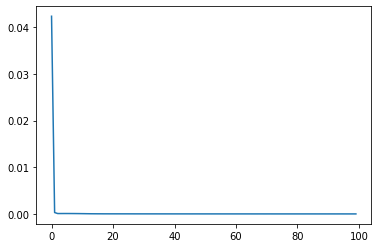

In [105]:
plt.plot(rediction.history["loss"])

In [14]:
preds = model.evaluate(x_test, y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

32/32 [==============================] - 1s 34ms/step - loss: 3.6038e-05 - accuracy: 0.5240
Loss = 3.603815639507957e-05
Test Accuracy = 0.5239999890327454


In [ ]:
Y_data=x_train[10]
Y_data=Y_data.reshape(1,100,100,-1)
print(Y_data.shape)
q=model.predict(Y_data)
print(q)
print(y_train[10])
mse = tf.keras.losses.MeanAbsoluteError()
error=mse(q, y_train[10]).numpy()
print(error)
# print(q-y_train[100])